# Catégorisez automatiquement des questions - Stack Overflow

#### Objectif: 
Développement d'un système de suggestion de tags via une API pour facilité la recherche aux utilisateurs sur le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.


Dans ce notebook:  
- Vectorisation 
- Entrainement des modèles 

### Sommaire

* [Import](#chapter1)
    * [Librairies](#section_1_1)
    * [Données](#section_1_2)
 
 
* [Les fonctions](#chapter2)
    * [Nettoyage](#section_2_1)
    * [Vectorization](#section_2_2)
    * [Représentation](#section_2_3)


* [Vectorization](#chapter3)
    * [Bag of Word & Tf idf](#section_3_1)
    * [Word Embeddings](#section_3_2)
        * [Word2Vect](#section_3_2_1)
        * [Bert](#section_3_2_2)
        * [USE](#section_3_2_3)  


* [Modélisation](#chapter4)
    * [Non supervisée: Latent Dirichlet Allocation](#section_4_1)
    * [Modélisation supervisée](#section_4_2)


## Import <a class="anchor" id="chapter1"></a>
### Librairies <a class="anchor" id="section_1_1"></a>

In [59]:
# Import des librairies
import numpy as np
import pandas as pd
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle

import time
from time import time

from collections import Counter

from bs4 import BeautifulSoup

# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

# Modélisation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# LDA modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Visualize data
import pyLDAvis
import pyLDAvis.gensim_models


logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [60]:
import tensorflow

In [5]:
pip uninstall texthero --yes

Found existing installation: texthero 1.1.0
Uninstalling texthero-1.1.0:
  Successfully uninstalled texthero-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install git+https://github.com/jbesomi/texthero.git

  Cloning https://github.com/jbesomi/texthero.git to /private/var/folders/10/jlfw_94j1wbc9s6xjrtpxj8c0000gn/T/pip-req-build-7g3vh6d_
  Running command git clone --filter=blob:none --quiet https://github.com/jbesomi/texthero.git /private/var/folders/10/jlfw_94j1wbc9s6xjrtpxj8c0000gn/T/pip-req-build-7g3vh6d_
  Resolved https://github.com/jbesomi/texthero.git to commit 25728bb0670e6410c76f2a9bbe6f1dba9f54fa67
  Preparing metadata (setup.py) ... done
  Using cached gensim-4.2.0-cp39-cp39-macosx_10_9_x86_64.whl (24.0 MB)
  Created wheel for texthero: filename=texthero-1.0.9-py3-none-any.whl size=42818 sha256=b8d0e9e12438e5aa538b34fa5fa1a976e8e2c4da59fa2a0813a1db58d671abb0
  Stored in directory: /private/var/folders/10/jlfw_94j1wbc9s6xjrtpxj8c0000gn/T/pip-ephem-wheel-cache-bs7wsfd6/wheels/e4/b8/12/af9a709743e0db6147aa12a14b1f10acc25ce98eed29678c08
Successfully built texthero
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.1
    Uninstalling gensim-3.8.1:
      Succ

In [61]:
import texthero as hero

In [62]:
#Word2Vec
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import tensorflow_hub as hub

In [63]:
# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [6]:
#import warnings
#warnings.filterwarnings("ignore",category=DepreciationWarning)

In [7]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
False


### Nos données <a class="anchor" id="section_1_2"></a>

In [64]:
data = pd.read_csv('processed_data.csv')

In [65]:
data = data.drop(['Unnamed: 0'],axis=1)

In [66]:
data.shape 

(24882, 9)

In [10]:
data.head(1)

CreationDate                                    Title  \
0  2008-07-31 21:42:52  How to convert Decimal to Double in C#?   

                                                Body  \
0  <p>I want to assign the decimal variable &quot...   

                                               Tags  \
0  c#,floating-point,type-conversion,double,decimal   

                                                Text  \
0  How to convert Decimal to Double in C#?<p>I wa...   

                                        Cleaned_text  body_tokens_count  \
0  convert decimal double want assign variable tr...                 16   

   number_of_tags top_tags  
0               1       c#

In [67]:
data["Tags"].nunique()

24414

In [54]:
data.shape

(24600, 9)

In [11]:
data = data.head(24600)

In [12]:
data.shape

(24600, 9)

## Fonctions <a class="anchor" id="chapter2"></a>
### Nattoyages <a class="anchor" id="section_2_1"></a>

In [68]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def remove_code(html):
    # parse html content
    soup = BeautifulSoup(html, "html.parser")  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()  
    # return data by retrieving the tag content
    return soup.stripped_strings

def regex(text):
    
    # Remove html tags
    text=re.sub(r"<[^>]*>",' ', text)
    # Remove usernames "@"
    text=re.sub(r'@\S+', ' ', text)
    # Remove hashtags
    text=re.sub(r'#\S+', ' ', text)
    # Remove punctuation
    text=re.sub(r'[^\w\s]', ' ', text)
    # Remove unicode characters
    text = text.encode("ascii", "ignore").decode()
    # Remove irrelevant characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove English contractions
    text = re.sub("\'\w+", '', text)
    # Remove extra spaces
    text = re.sub('\s+', ' ', text)
    # Remove numbers
    text = re.sub(r'\w*\d+\w*', '', text)
    # Remove links
    text = re.sub(r'http*\S+', '', text)
    # Remove whitespace
    text=re.sub(r'^\s*|\s\s*', ' ', text).strip()
    text=text.replace('\n', '')
    
    return text

def remov_duplicates(input):
 
    # split input string separated by space
    input = input.split(" ")
 
    # now create dictionary using counter method
    # which will have strings as key and their
    # frequencies as value
    UniqW = Counter(input)
 
    # joins two adjacent elements in iterable way
    s = " ".join(UniqW.keys())
    
    return s

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
                                       and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Remove single character
def remove_single_char_func(text, threshold=1):
    threshold = threshold
    words = word_tokenize(text)
    text = ''.join([w for w in words if len(w) > threshold])
    return text

# Lemmatizer (base d'un mot) with NLTK
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


<>:29: DeprecationWarning:

invalid escape sequence \w

<>:31: DeprecationWarning:

invalid escape sequence \s

<>:29: DeprecationWarning:

invalid escape sequence \w

<>:31: DeprecationWarning:

invalid escape sequence \s

/var/folders/10/jlfw_94j1wbc9s6xjrtpxj8c0000gn/T/ipykernel_19439/1008289869.py:29: DeprecationWarning:

invalid escape sequence \w

/var/folders/10/jlfw_94j1wbc9s6xjrtpxj8c0000gn/T/ipykernel_19439/1008289869.py:31: DeprecationWarning:

invalid escape sequence \s



In [69]:
# Lemmatization with Spacy
# Lemmatization = reduction of word to their core root form, their "lemma"
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text =[]
        # iterate for token and docs, for each of the word in the text
        for token in doc:
            if token.pos_ in allowed_postags: # pos = part of speech
                new_text.append(token.lemma_) # lemma_ for the lemmatized form, to append the lemma itself and not the word to reduce the complexity of the text, and by having fewer words in it.
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out) # Pass in a single text 

In [70]:
def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested. 

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame 
        DataFrame to extend. 
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

### Préparation pour la vectorization <a class="anchor" id="section_2_2"></a>

In [71]:
# Fonction de preparation du text pour la vectorization bag of word, Tf idf et Word2Vec

def transform_bow_fct(desc_text) :
    text_regex = regex(desc_text.lower())
    text_remove_duplicated = remov_duplicates(text_regex)
    word_tokens = tokenizer_fct(text_remove_duplicated)
    sw = stop_word_filter_fct(word_tokens)
    lem_w = lemma_fct(sw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

In [72]:
# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    text_regex = regex(desc_text.lower())
    text_remove_duplicated = remov_duplicates(text_regex)
    word_tokens = tokenizer_fct(text_remove_duplicated)
    transf_desc_text = ' '.join(word_tokens)
    return transf_desc_text

### Représentation graphique <a class="anchor" id="section_2_2"></a>

In [73]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des questions par tags')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des questions par clusters')
    
    plt.show()
    print("ARI : ", ARI)


In [74]:
data['Cleaned_text'] = data['Cleaned_text'].astype("string")

In [75]:
data['Text'] = data['Text'].astype("string")

In [76]:
data['sentence_bow'] = data['Text'].apply(lambda x : transform_bow_fct(x))
data['sentence_dl'] = data['Text'].apply(lambda x : transform_dl_fct(x))
data.shape

(24882, 11)

In [77]:
from nltk.tokenize import sent_tokenize, word_tokenize

data['length_bow'] = data['sentence_bow'].apply(lambda x : len(word_tokenize(str(x))))
max_length_bow = data['length_bow'].max()
print("max length bow : ", max_length_bow)

data['length_dl'] = data['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
max_length_dl = data['length_dl'].max()
print("max length dl : ", max_length_dl)

max length bow :  727
max length dl :  860


In [78]:
print(data[data['length_dl']==1076]['sentence_dl'])
data['sentence_dl'][171]

Series([], Name: sentence_dl, dtype: object)


'java net socketexception connection reset i am getting the following error trying to read from a socket m doing readint on that inputstream and this perusing documentation suggests client part of closed in scenario server have access log files it is not closing fact its suggest so does anybody an idea why happening what else check for arise when there are local resources perhaps reaching thresholds do note line setsotimeout just prior reason long story but curious circumstances under which might lead indicated running my ide happened leave stuck breakpoint then noticed exact same errors begin appearing own logs anyway mentioning hopefully red herring'

In [79]:
data['length_text_brut'] = data['Text'].apply(lambda x : len(word_tokenize(str(x))))
max_length_data_brut = data['length_text_brut'].max()
print("max length Text : ", max_length_data_brut)

max length Text :  8053


In [80]:
data['length_cleaned_text'] = data['Cleaned_text'].apply(lambda x : len(word_tokenize(str(x))))
max_length_cleaned_data = data['length_cleaned_text'].max()
print("max length Cleaned_text : ", max_length_cleaned_data)

max length Cleaned_text :  738


## Vectorization <a class="anchor" id="chapter3"></a>
### Bag of word & Tf-idf <a class="anchor" id="section_3_1"></a>

In [81]:
# Derinir X et y

X=data['sentence_bow']
y=data['top_tags']

In [82]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialisation de Countvectorizer() pour BoW et de TfidfVectorizer() pour Tfidf
# Eliminer les mots qui apparaissent dans plus de 60% des documents (max_df = 0.6).
cvect = CountVectorizer(analyzer="word", stop_words='english', max_df=0.6, min_df=0.005)
ctf = TfidfVectorizer(analyzer="word", stop_words='english', max_df=0.6, min_df=0.005)

# Fit&transform modèle
cv_fit = cvect.fit(X)
ctf_fit = ctf.fit(X)

X_BoW = cvect.transform(X)  
X_tfidf = ctf.transform(X)  

In [83]:
print("Shape of y: {}".format(y.shape))
print("Shape of X for the Title&Text in BoW: {}".format(X_BoW.shape))
print("Shape of X for Title&Text in Tf-idf: {}".format(X_tfidf.shape))

Shape of y: (24882,)
Shape of X for the Title&Text in BoW: (24882, 1601)
Shape of X for Title&Text in Tf-idf: (24882, 1601)


In [84]:
full_dense_X_BoW = X_BoW.todense()
full_dense_X_tfidf = X_tfidf.todense()

print("X BoW sparsicity: {:.3f} %"\
      .format(((full_dense_X_BoW > 0).sum()/full_dense_X_BoW.size)*100))
print("X Tf-idf sparsicity: {:.3f} %"\
      .format(((full_dense_X_tfidf > 0).sum()/full_dense_X_tfidf.size)*100))

X BoW sparsicity: 2.325 %
X Tf-idf sparsicity: 2.325 %


In [85]:
l_cat = list(set(data['top_tags']))
print("catégories : ", l_cat)

catégories :  ['javascript, linux, node.js', 'python, database, django', 'ios, objective-c, iphone, xcode', 'c++, multithreading, algorithm', 'python, html, ruby', 'c++, python, python-3.x', 'javascript, iphone, android, ios, html', 'jquery, image', 'php, mysql, image', 'objective-c, git', 'c++, python, arrays', 'asp.net-mvc, string', 'javascript, jquery, html, ajax', 'asp.net, r', 'javascript, arrays, string', 'python-3.x, numpy', 'html, linux, bash', 'c#, jquery, ajax, asp.net-mvc', 'ruby-on-rails, git', 'python, string, pandas, numpy', 'arrays, node.js', 'java, php, javascript', 'iphone, objective-c, ios, cocoa-touch', 'ruby-on-rails, ruby, ajax', 'javascript, php, jquery, ajax', 'c#, .net, android', 'ios, arrays, swift, string', 'xcode, ios', 'python, c, windows', 'java, android, ios', 'performance', 'javascript, jquery, ios, css', 'swift', 'android, html, css', 'arrays, string, algorithm', 'python, python-3.x, pandas, numpy', 'java, unit-testing, spring', 'c++, python, c', 'php, j

In [86]:
y_cat_num = [(1-l_cat.index(data.iloc[i]['top_tags'])) for i in range(len(data))]

In [87]:
# Multilabel binarizer for targets

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform(data['top_tags'].str.split(', '))

print(" Les différent sujets sont: \n{}".format(mlb.classes_))
print('\n')
print("Shape of y_binarized: {}".format(y_binarized.shape))

 Les différent sujets sont: 
['.net' 'ajax' 'algorithm' 'android' 'arrays' 'asp.net' 'asp.net-mvc'
 'bash' 'c' 'c#' 'c++' 'c++11' 'cocoa-touch' 'css' 'database' 'django'
 'git' 'html' 'image' 'ios' 'iphone' 'java' 'javascript' 'jquery' 'json'
 'linux' 'macos' 'multithreading' 'mysql' 'node.js' 'numpy' 'objective-c'
 'pandas' 'performance' 'php' 'python' 'python-3.x' 'r' 'ruby'
 'ruby-on-rails' 'shell' 'spring' 'sql' 'sql-server' 'string' 'swift'
 'unit-testing' 'windows' 'wpf' 'xcode']


Shape of y_binarized: (24882, 50)


In [225]:
filename_mlb_model = './models/mlb_model.pkl'
pickle.dump(mlb, open(filename_mlb_model,'wb'))

In [88]:
df_y_binarized = pd.DataFrame(y_binarized,columns=mlb.classes_)
df_y_binarized

.net  ajax  algorithm  android  arrays  asp.net  asp.net-mvc  bash  c  \
0         0     0          0        0       0        0            0     0  0   
1         0     0          0        0       0        0            0     0  0   
2         0     0          0        0       0        0            0     0  0   
3         0     0          1        0       0        0            0     0  0   
4         0     0          0        0       0        0            0     0  0   
...     ...   ...        ...      ...     ...      ...          ...   ... ..   
24877     0     0          0        0       0        0            0     0  0   
24878     0     0          0        0       0        0            0     0  0   
24879     0     0          0        1       0        0            0     0  0   
24880     0     0          0        0       0        0            0     0  0   
24881     0     0          0        0       0        0            0     0  0   

       c#  ...  shell  spring  sql  sql-server  string  swift  unit-testing  \
0       1  ...      0       0    0           0       0      0             0   
1       1  ...      0       0    0           0       0      0             0   
2       0  ...      0       0    0           0       0      0             0   
3       0  ...      0       0    0           0       0      0             0   
4       0  ...      0       0    0           0       0      0             0   
...    ..  ...    ...     ...  ...         ...     ...    ...           ...   
24877   0  ...      0       0    0           0       0      0             0   
24878   0  ...      0       0    0           0       0      0             0   
24879   0  ...      0       0    0           0       0      0             0   
24880   0  ...      0       0    0           0       0      0             0   
24881   0  ...      0       0    0           0       1      0             0   

       windows  wpf  xcode  
0            0    0      0  
1            0    0      0  
2            0    0      0  
3            0    0      0  
4            0    0      0  
...        ...  ...    ...  
24877        0    0      0  
24878        0    0      0  
24879        0    0      0  
24880        0    0      0  
24881        0    0      0  

[24882 rows x 50 columns]

#### PCA

In [32]:
data.head(2)

CreationDate                                    Title  \
0  2008-07-31 21:42:52  How to convert Decimal to Double in C#?   
1  2008-07-31 23:55:37            Calculate relative time in C#   

                                                Body  \
0  <p>I want to assign the decimal variable &quot...   
1  <p>Given a specific <code>DateTime</code> valu...   

                                               Tags  \
0  c#,floating-point,type-conversion,double,decimal   
1      c#,datetime,time,datediff,relative-time-span   

                                                Text  \
0  How to convert Decimal to Double in C#?<p>I wa...   
1  Calculate relative time in C#<p>Given a specif...   

                                        Cleaned_text  body_tokens_count  \
0  convert decimal double want assign variable tr...                 16   
1  calculate relative time give specific datetime...                 13   

   number_of_tags top_tags                                       sentence_bow  \
0               1       c#  convert decimal double want assign variable qu...   
1               1       c#  calculate relative time given specific datetim...   

                                         sentence_dl  length_bow  length_dl  \
0  how to convert decimal double in c i want assi...          18         29   
1  calculate relative time in c given a specific ...          13         19   

   length_text_brut  length_cleaned_text  
0               107                   16  
1                84                   13

In [32]:
X_tfidf.shape

(24600, 1595)

In [89]:
data_pca = data.head(5000)
data_pca.shape

(5000, 15)

In [34]:
data['sentence_bow'].shape

(24600,)

In [90]:
data_pca['pca'] = (
                data_pca['sentence_bow']
                .pipe(hero.tfidf)
                .pipe(hero.pca)
               
              )

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/texthero/representation.py:267: DeprecationWarning:

It seems like the given Pandas Series s is not tokenized. This function will tokenize it automatically using hero.tokenize(s) first. You should consider tokenizing it yourself first with hero.tokenize(s) in the future.

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/texthero/preprocessing.py:693: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/var/folders/10/jlfw_94j1wbc9s6xjrtpxj8c0000gn/T/ipykernel_19439/3021917092.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [91]:
data_pca.head(3)

CreationDate                                    Title  \
0  2008-07-31 21:42:52  How to convert Decimal to Double in C#?   
1  2008-07-31 23:55:37            Calculate relative time in C#   
2  2008-08-01 00:42:38              Determine a user's timezone   

                                                Body  \
0  <p>I want to assign the decimal variable &quot...   
1  <p>Given a specific <code>DateTime</code> valu...   
2  <p>Is there a standard way for a web server to...   

                                               Tags  \
0  c#,floating-point,type-conversion,double,decimal   
1      c#,datetime,time,datediff,relative-time-span   
2  html,browser,timezone,user-agent,timezone-offset   

                                                Text  \
0  How to convert Decimal to Double in C#?<p>I wa...   
1  Calculate relative time in C#<p>Given a specif...   
2  Determine a user's timezone<p>Is there a stand...   

                                        Cleaned_text  body_tokens_count  \
0  convert decimal double want assign variable tr...                 16   
1  calculate relative time give specific datetime...                 13   
2  determine user timezone standard way web serve...                 15   

   number_of_tags top_tags                                       sentence_bow  \
0               1       c#  convert decimal double want assign variable qu...   
1               1       c#  calculate relative time given specific datetim...   
2               1     html  determine user timezone standard way web serve...   

                                         sentence_dl  length_bow  length_dl  \
0  how to convert decimal double in c i want assi...          18         29   
1  calculate relative time in c given a specific ...          13         19   
2  determine a user s timezone is there standard ...          15         27   

   length_text_brut  length_cleaned_text  \
0               107                   16   
1                84                   13   
2                58                   15   

                                         pca  
0   [-3.512054949224721, 1.2528180016651007]  
1  [-3.650938811257591, -0.5158734596291774]  
2  [-3.413752829815649, -0.1863174402241548]

In [92]:
hero.scatterplot(
    data_pca,
    color='top_tags',
    col='pca',
    title='PCA text & body'
)

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [93]:
data_top_5_tags = data_pca.loc[data_pca['top_tags'].isin(['python','javascript','c#','java','ios'])]
data_top_5_tags.head(3)

CreationDate                                          Title  \
0   2008-07-31 21:42:52        How to convert Decimal to Double in C#?   
1   2008-07-31 23:55:37                  Calculate relative time in C#   
13  2008-08-04 18:20:36  How do you express binary literals in Python?   

                                                 Body  \
0   <p>I want to assign the decimal variable &quot...   
1   <p>Given a specific <code>DateTime</code> valu...   
13  <p>How do you express an integer as a binary n...   

                                                Tags  \
0   c#,floating-point,type-conversion,double,decimal   
1       c#,datetime,time,datediff,relative-time-span   
13             python,syntax,binary,integer,literals   

                                                 Text  \
0   How to convert Decimal to Double in C#?<p>I wa...   
1   Calculate relative time in C#<p>Given a specif...   
13  How do you express binary literals in Python?<...   

                                         Cleaned_text  body_tokens_count  \
0   convert decimal double want assign variable tr...                 16   
1   calculate relative time give specific datetime...                 13   
13  express binary literal python integer number e...                 32   

    number_of_tags top_tags  \
0                1       c#   
1                1       c#   
13               1   python   

                                         sentence_bow  \
0   convert decimal double want assign variable qu...   
1   calculate relative time given specific datetim...   
13  express binary literal python integer number e...   

                                          sentence_dl  length_bow  length_dl  \
0   how to convert decimal double in c i want assi...          18         29   
1   calculate relative time in c given a specific ...          13         19   
13  how do you express binary literals in python a...          32         62   

    length_text_brut  length_cleaned_text  \
0                107                   16   
1                 84                   13   
13               334                   32   

                                           pca  
0     [-3.512054949224721, 1.2528180016651007]  
1    [-3.650938811257591, -0.5158734596291774]  
13  [-2.0097385018539855, -0.8977906872629289]

In [94]:
data_top_5_tags['pca'] = (
                data_top_5_tags['sentence_bow']
                .pipe(hero.tfidf)
                .pipe(hero.pca)
               
              )

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/texthero/representation.py:267: DeprecationWarning:

It seems like the given Pandas Series s is not tokenized. This function will tokenize it automatically using hero.tokenize(s) first. You should consider tokenizing it yourself first with hero.tokenize(s) in the future.

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/texthero/preprocessing.py:693: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/var/folders/10/jlfw_94j1wbc9s6xjrtpxj8c0000gn/T/ipykernel_19439/1558815426.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [95]:
hero.scatterplot(
    data_top_5_tags,
    color='top_tags',
    col='pca',
    title='PCA text & body'
)

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



#### Create train and test split

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.2, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (19905, 1601)
X_test shape : (4977, 1601)
y_train shape : (19905, 50)
y_test shape : (4977, 50)


## Words Embeddings <a class="anchor" id="section_3_2"></a>

### Word2Vec <a class="anchor" id="section_3_2_1"></a>

In [ ]:
# Understanding Word Vectors by Allison Parrish: https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469
# The Coding Train: https://www.youtube.com/watch?v=LSS_bos_TPI
# The Semicolon : https://www.youtube.com/watch?v=UqRCEmrv1gQ

In [122]:
# Prepare inputs for embedding
corpus = data['sentence_bow'].values.tolist()
tokenized_corpus = [nltk.word_tokenize(sent) for sent in corpus]

In [113]:
max_length_bow

727

In [137]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = max_length_bow # adapt to length of sentences

In [139]:
# Création et entraînement du modèle Word2Vec

print("Modèle Word2Vec:")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, # Ignore words that appear less than this
                                   window=w2v_window,       # Context window for words during training
                                   vector_size=w2v_size,    # Dimensionality of word embeddings
                                   seed=42,
                                   sg = 1,                  # skipgrams
                                   workers=1)

t = time()
workers=multiprocessing.cpu_count() # Count the number of cores in a computer
w2v_model.build_vocab(tokenized_corpus)
w2v_model.train(tokenized_corpus, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key

print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Modèle Word2Vec:
Vocabulary size: 90672
Word2Vec trained
Time to build vocab: 25.26 mins
Time to train the model: 25.26 mins


In [129]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [140]:
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print(len(w2v_words))

90672


In [141]:
w2v_model.wv.most_similar('code')

[('userview', 0.40419331192970276),
 ('cartopy', 0.4027804136276245),
 ('mypoint', 0.3994652032852173),
 ('fileversioninfo', 0.38931283354759216),
 ('ibdesignable', 0.3852353096008301),
 ('greeterfactory', 0.38003212213516235),
 ('adminportal', 0.3781808912754059),
 ('testbasicexample', 0.3759894371032715),
 ('bootloaders', 0.37546539306640625),
 ('mappingcontroller', 0.3734259009361267)]

In [142]:
w2v_model.wv.most_similar('function')

[('updatebtn', 0.4143073260784149),
 ('ajaxspl', 0.41069623827934265),
 ('shortfunctionsecond', 0.4080568850040436),
 ('ajaxurl', 0.4056723415851593),
 ('iable', 0.40454310178756714),
 ('printcontents', 0.4025193154811859),
 ('printdiv', 0.40204328298568726),
 ('putimage', 0.40134596824645996),
 ('valbox', 0.3997775912284851),
 ('functionproxy', 0.3974323868751526)]

In [143]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_corpus)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(tokenized_corpus),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 90673


In [154]:
from collections import defaultdict  # For word frequency
word_freq = defaultdict(int)
for s in tokenized_corpus:
    for i in s:
        word_freq[i] += 1
        
len(word_freq)

90672

In [155]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['using', 'like', 'use', 'get', 'code', 'way', 'work', 'want', 'would', 'file']

In [150]:
tokenizer.word_index

{'using': 1,
 'like': 2,
 'use': 3,
 'get': 4,
 'code': 5,
 'way': 6,
 'work': 7,
 'want': 8,
 'would': 9,
 'file': 10,
 'one': 11,
 'need': 12,
 'new': 13,
 'know': 14,
 'class': 15,
 'example': 16,
 'return': 17,
 'error': 18,
 'question': 19,
 'data': 20,
 'problem': 21,
 'method': 22,
 'user': 23,
 'following': 24,
 'function': 25,
 'also': 26,
 'make': 27,
 'value': 28,
 'time': 29,
 'application': 30,
 'set': 31,
 'trying': 32,
 'string': 33,
 'type': 34,
 'name': 35,
 'object': 36,
 'something': 37,
 'app': 38,
 'tried': 39,
 'find': 40,
 'run': 41,
 'could': 42,
 'create': 43,
 'see': 44,
 'however': 45,
 'add': 46,
 'found': 47,
 'used': 48,
 'com': 49,
 'server': 50,
 'help': 51,
 'call': 52,
 'result': 53,
 'solution': 54,
 'possible': 55,
 'project': 56,
 'first': 57,
 'change': 58,
 'version': 59,
 'public': 60,
 'test': 61,
 'seems': 62,
 'working': 63,
 'two': 64,
 'line': 65,
 'thanks': 66,
 'without': 67,
 'look': 68,
 'case': 69,
 'list': 70,
 'update': 71,
 'read': 7

In [157]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Création de la matrice d'embedding
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (90673, 300)


In [158]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')

word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)

word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 727)]             0         
                                                                 
 embedding (Embedding)       (None, 727, 300)          27201900  
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 27,201,900
Trainable params: 27,201,900
Non-trainable params: 0
_________________________________________________________________


In [159]:
# Exécution du modèle
embeddings = embed_model.predict(x_sentences)
embeddings.shape

778/778 [==============================] - 2s 3ms/step


(24882, 300)

In [306]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.0068 time :  652.0


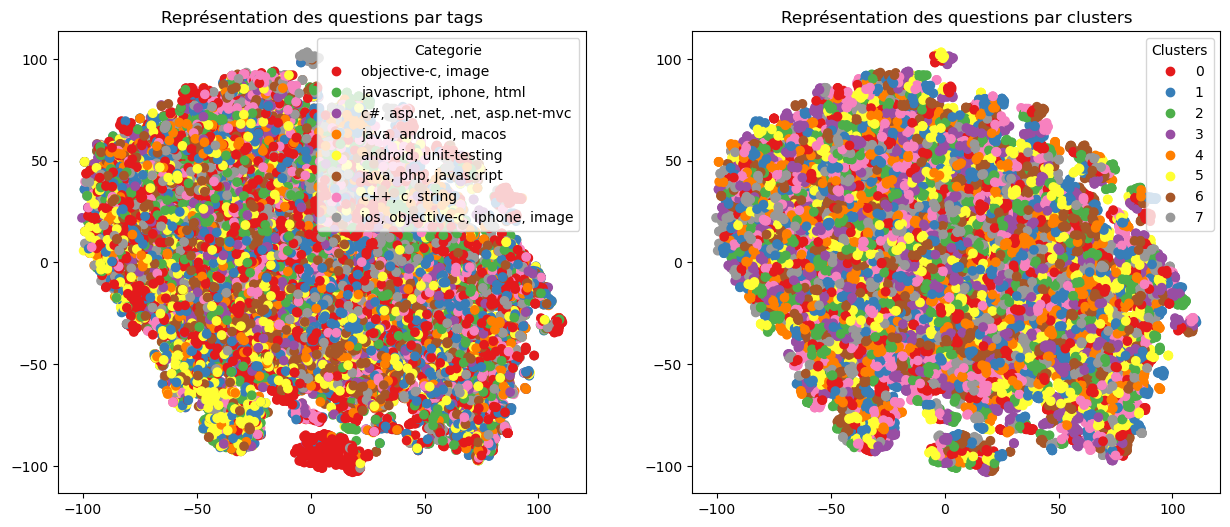

ARI :  0.0068


In [307]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### ACP

In [ ]:
X = numpy.array(embeddings)

### BERT <a class="anchor" id="section_3_2_2"></a>

#### Les Fonctions

In [337]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### BERT HuggingFace

In [35]:
#pip install --upgrade torch torchvision

In [362]:
max_length = 64
batch_size = 600
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type,from_pt=True)

In [357]:
len(data['sentence_dl'])

24600

In [361]:
len(sentences)

24600

In [359]:
sentences = data['sentence_dl'].to_list()

In [363]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 61s 61s/step
temps traitement :  3186.0


In [364]:
features_bert.shape

(24600, 768)

In [365]:
len(y_cat_num,)

24600

In [366]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.0022 time :  5943.0


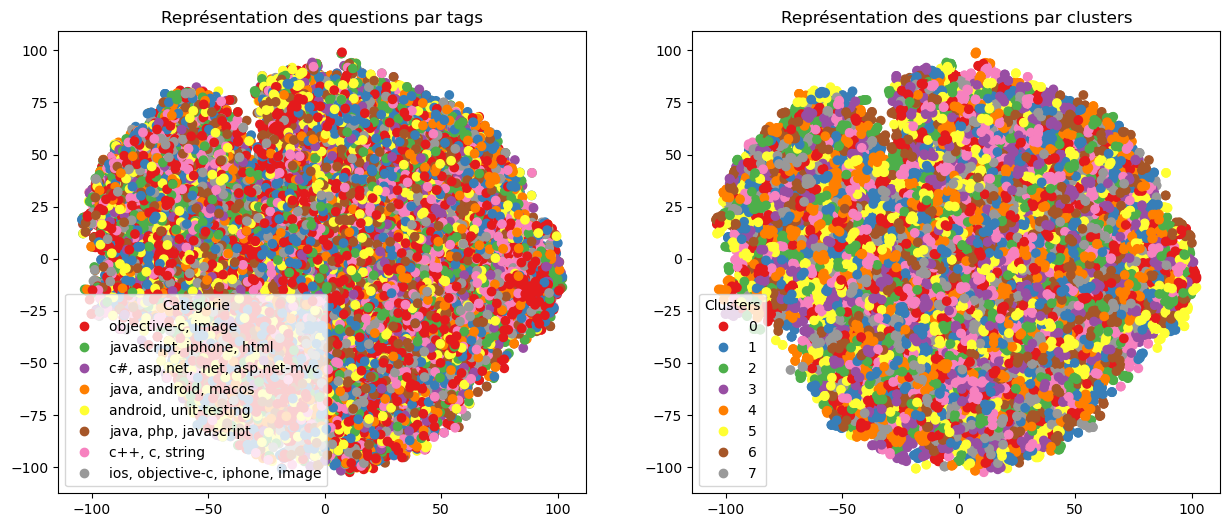

ARI :  0.0022


In [367]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Universal Sentence Encoder <a class="anchor" id="section_3_2_3"></a>

In [315]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [316]:
# Fonction
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time() - time1,0)
    return features

In [368]:
batch_size = 600
sentences = data['sentence_dl'].to_list()

In [369]:
features_USE = feature_USE_fct(sentences, batch_size)

In [370]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.0133 time :  827.0


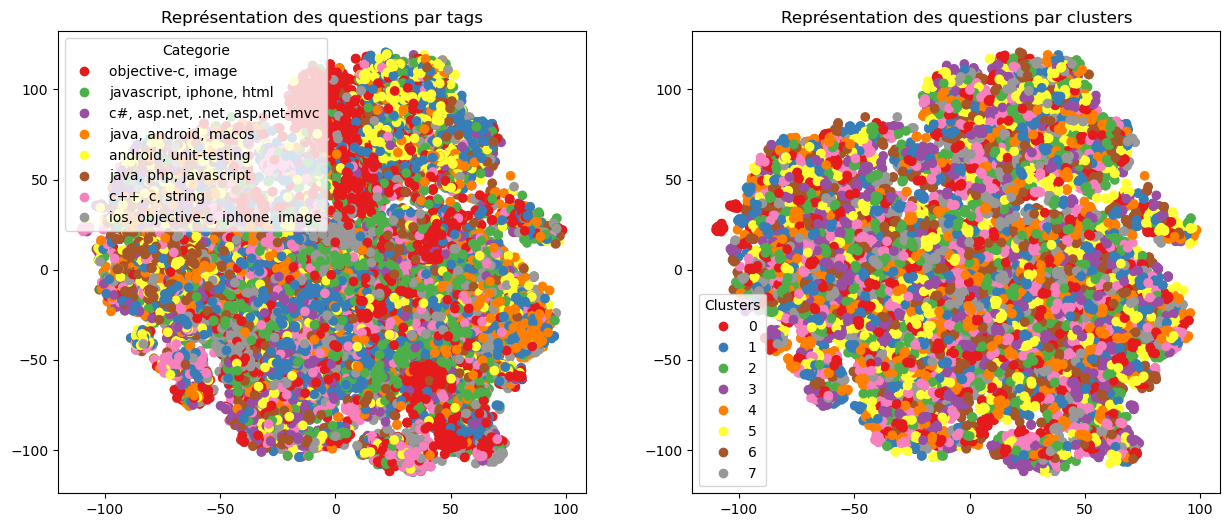

ARI :  0.0133


In [371]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## Modélisation <a class="anchor" id="chapter4"></a>
### Non-supervisée: Latent Dirichlet Allocation <a class="anchor" id="section_4_1"></a>

In [97]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Visualize data
from pyLDAvis._display import *
import pyLDAvis
import pyLDAvis.gensim_models


#### Prepare the text for the model : lemmatize with Spacy & remove stopwords

In [100]:
# To reduce the text to individual words and remove stopwords
def gen_words(texts):
    final = []
    for text in texts: # iterate over all the text
        new = genism.utils.simple_preprocess(text, deacc=True) # deac stands for d accent, it's a boolean true or false, by default it's false. We make it true to make sure that if we have words with accent, they will still be normalized to reduce the complexity of the model
        final.append(new)
    return (final)

#### Prétraitement

In [103]:
X = data['sentence_bow']
y = data["top_tags"]

In [104]:
sentences = data['sentence_bow'].to_list()
sentences

['convert decimal double want assign variable quot trans opacity trackbar value build app give following error implicitly type',
 'calculate relative time given specific datetime value display like hour ago day month',
 'determine user timezone standard way web server able within page perhaps header part agent string',
 'fastest way get value looking obtain personal challenge specifically using way involve constant like hard coding number program test various know inline assembly version theory option though clearly portable included baseline compare version built in atan gcc auto fold constant fno builtin specified main testing pitimes math stdio time iters testwith diff clock printf diffclock static double return clock per sec int warmup case catch folding would optimise used defined gnuc amp amd extern fldpi actual start acos asin stuff work system asm build script build configuration wall ffast apart compiler flag compared bit optimization different also tried switching order aroun

In [105]:
corpus = X.values.tolist()
X = [nltk.word_tokenize(sent) for sent in corpus]

In [106]:
# Create dictionnary (bag of words)

id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)

# Create Corpus 
texts = X 

# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  

# View 
print(corpus[:1]) # to view the index from each word in the Gensim dictionnary

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [108]:
filename_dictionary = 'models/dictionary.pkl'
pickle.dump(id2word, open(filename_dictionary,'wb'))

In [109]:
word = id2word[[0][:1][0]]
print (word)

app


In [112]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('app', 1),
  ('assign', 1),
  ('build', 1),
  ('convert', 1),
  ('decimal', 1),
  ('double', 1),
  ('error', 1),
  ('following', 1),
  ('give', 1),
  ('implicitly', 1),
  ('opacity', 1),
  ('quot', 1),
  ('trans', 1),
  ('type', 1),
  ('value', 1),
  ('variable', 1),
  ('want', 1)],
 [('value', 1),
  ('ago', 1),
  ('calculate', 1),
  ('datetime', 1),
  ('day', 1),
  ('display', 1),
  ('given', 1),
  ('hour', 1),
  ('like', 1),
  ('month', 1),
  ('relative', 1),
  ('specific', 1),
  ('time', 1)],
 [('able', 1),
  ('agent', 1),
  ('determine', 1),
  ('header', 1),
  ('page', 1),
  ('part', 1),
  ('perhaps', 1),
  ('server', 1),
  ('standard', 1),
  ('string', 1),
  ('timezone', 1),
  ('user', 1),
  ('way', 1),
  ('web', 1),
  ('within', 1)],
 [('build', 2),
  ('double', 1),
  ('value', 1),
  ('like', 1),
  ('time', 1),
  ('way', 2),
  ('acos', 1),
  ('actual', 1),
  ('also', 1),
  ('amd', 1),
  ('amp', 1),
  ('apart', 1),
  ('around', 1),
  ('asin', 1),
  ('asm', 1),
  ('assembly', 1)

In [113]:
# Build LDA model
full_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', full_lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.28914938845848

Coherence Score:  0.4086643361742799


In [114]:
# Iter LDA for best number of topics
from time import time
import time

coherence_test = []
for k in np.arange(1,50,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 11
Fitting LDA for K = 21
Fitting LDA for K = 31
Fitting LDA for K = 41


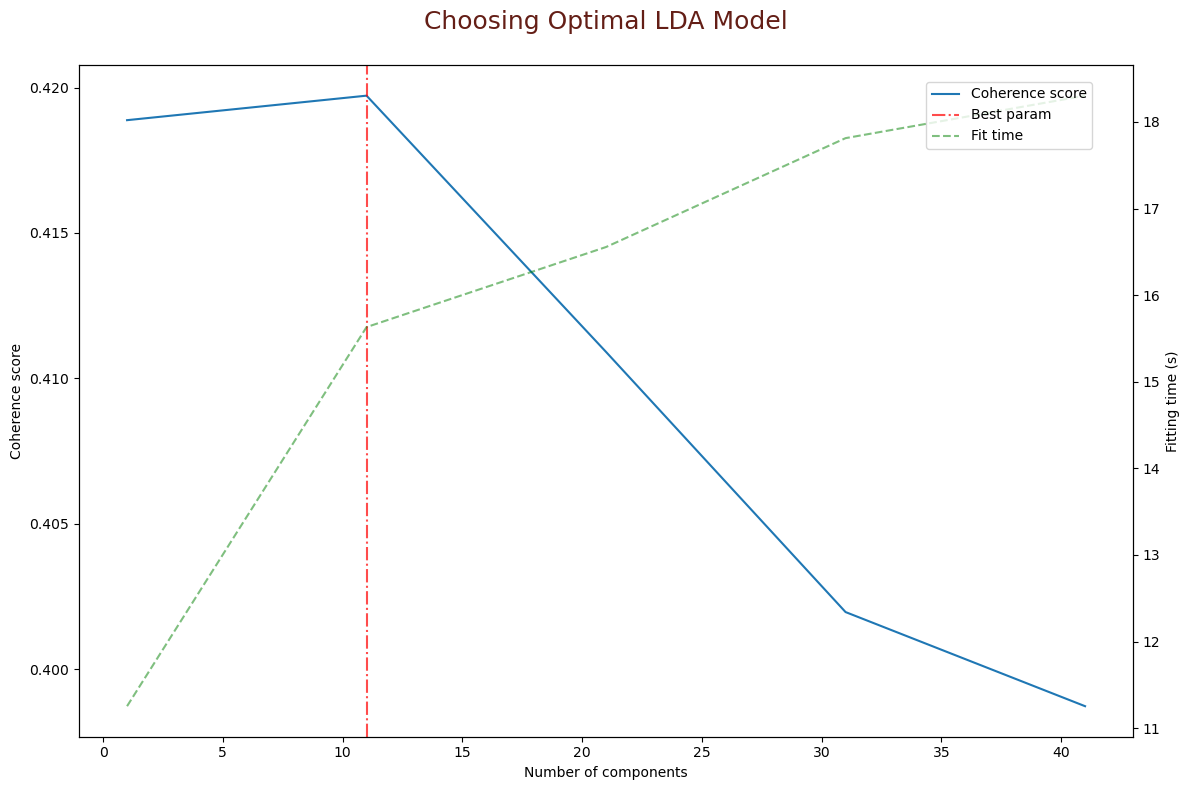

<Figure size 640x480 with 0 Axes>

In [115]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()
plt.savefig("Choosing Optimal LDA Model\n",transparent=True)

In [116]:
best_nb_topics

11

In [117]:
# Build optimized LDA model
lda_opt = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_nb_topics,
                                  random_state=8,  
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', lda_opt.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_opt, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.118960453388064

Coherence Score:  0.4155759039837817


In [126]:
tf_feature_names = cvect.get_feature_names()
tf_feature_names

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['ability',
 'able',
 'absolute',
 'abstract',
 'accept',
 'accepted',
 'access',
 'accessing',
 'accomplish',
 'according',
 'account',
 'achieve',
 'achieved',
 'act',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'adapter',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'address',
 'admin',
 'advance',
 'advantage',
 'advice',
 'affect',
 'age',
 'agent',
 'ago',
 'ajax',
 'alert',
 'algorithm',
 'align',
 'alloc',
 'allow',
 'allowed',
 'allows',
 'alpha',
 'alternative',
 'amp',
 'analysis',
 'android',
 'angular',
 'angularjs',
 'animated',
 'animation',
 'annotation',
 'anonymous',
 'answer',
 'anybody',
 'anymore',
 'apache',
 'api',
 'apis',
 'apk',
 'app',
 'apparently',
 'appear',
 'appears',
 'append',
 'apple',
 'application',
 'applied',
 'apply',
 'appreciate',
 'appreciated',
 'approach',
 'appropriate',
 'apps',
 'arbitrary',
 'architecture',
 'archive',
 'area',
 'args',
 'argument',
 'argv',
 'array',
 'arraylist',
 'article',
 'ask',
 'asked

#### Vizualizing data

In [123]:
full_lda_model

In [124]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_opt, corpus, id2word, mds="mds", R=10)

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/past/builtins/misc.py:45: Deprec

/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/envs/Projet5/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are de

In [125]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005886 -0.030068       1        1  15.798775
7      0.005375 -0.007880       2        1  14.906527
8      0.005986 -0.007172       3        1  12.145132
5      0.000135  0.025934       4        1   9.891507
10     0.030414  0.008173       5        1   9.061387
4     -0.005381 -0.011731       6        1   8.354522
2      0.055813  0.003834       7        1   8.135678
1     -0.025980  0.031726       8        1   5.883232
3     -0.028080 -0.027698       9        1   5.824004
9     -0.023513  0.030226      10        1   5.369279
6     -0.008883 -0.015344      11        1   4.629958, topic_info=          Term         Freq        Total Category  logprob  loglift
249       file  6047.000000  6047.000000  Default  10.0000  10.0000
9005     swift   462.000000   462.000000  Default   9.0000   9.0000
84         get  8057.000000  8057.000000  Default   8.0000   8.0000
6        error  5591.000000  5591.000000  Default   7.0000   7.0000
746      class  4912.000000  4912.000000  Default   6.0000   6.0000
...        ...          ...          ...      ...      ...      ...
84         get   365.518951  8057.444093  Topic11  -5.1667  -0.0204
303   function   260.446579  4157.061851  Topic11  -5.5056   0.3025
41         way   295.032807  6538.897030  Topic11  -5.3809  -0.0258
243       code   309.447769  7719.437099  Topic11  -5.3332  -0.1441
132      would   280.171145  6032.966992  Topic11  -5.4326   0.0030

[348 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
11443      1  0.029336  accesstoken
11443      3  0.029336  accesstoken
11443      5  0.029336  accesstoken
11443      6  0.880094  accesstoken
11443      7  0.029336  accesstoken
...      ...       ...          ...
4195       7  0.103058         yyyy
4195       8  0.014723         yyyy
4195       9  0.014723         yyyy
4195      10  0.014723         yyyy
4195      11  0.014723         yyyy

[1614 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 9, 6, 11, 5, 3, 2, 4, 10, 7])

Création d'une matrice Topics/Tags (multiplication matricielle des matrices doc/topic et doc/tag)
pour atrribuer les tags à chaque questions dans notre modèle LDA

In [142]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(lda_opt\
                             .get_document_topics(corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (24882, 50)
document/topic :  (24882, 11)


In [143]:
# Print doc/topic matrix : La probabilité qu'un doc appartient au topic
doc_topic.head(3)

0         1         2         3         4         5         6   \
0  0.005056  0.005055  0.005056  0.231069  0.005055  0.005055  0.005056   
1  0.935039  0.006496  0.006496  0.006496  0.006496  0.006496  0.006496   
2  0.005684  0.005684  0.005684  0.005684  0.005684  0.005684  0.943162   

         7         8         9         10  
0  0.096857  0.005055  0.005055  0.631630  
1  0.006496  0.006496  0.006496  0.006496  
2  0.005684  0.005684  0.005684  0.005684

In [144]:
# Création matrice Topic/Tags
# Matricial multiplication with Document / Topics transpose:
# Les lignes representent les topics et les colonnes representent les tags associés et leur distribution
topic_tag = np.matmul(doc_topic.T, y_binarized)
topic_tag.shape

(11, 50)

In [145]:
topic_tag

0          1           2           3           4           5   \
0   159.332732  17.179512  229.035489  146.074994  110.963422   45.811839   
1    62.390718   1.409018   18.882997   66.510583   26.846396    9.883262   
2   202.805307  38.302351   14.601831  156.600495   41.611911  104.540703   
3    51.211843   1.896189   20.800448  274.463275   11.069076    5.413200   
4   157.286360  19.084429   44.585555  126.171842   30.388379   53.729782   
5    91.584590  26.397438    6.754527  315.987468    6.996285   45.198696   
6    68.520310  19.447925   45.973382   51.377635   26.746561   21.494599   
7   250.446715  23.771972   66.164284  112.109899  138.460408   38.318574   
8   222.022951  57.541962   11.562901  355.261226    7.653233  203.009299   
9    49.709497  51.580902    7.650717   72.043879    7.197183   24.135380   
10  120.688977  63.388301   15.987869  361.398704   41.067146   40.464669   

            6           7           8           9   ...          40  \
0    21.458983   24.278312  163.197792  296.454312  ...   21.859925   
1     6.587100  154.744844   44.144977   77.713673  ...  128.171750   
2   119.626389    4.068667   54.028393  500.800092  ...    3.172867   
3     1.702020   27.792161   59.379023   81.948394  ...   18.179468   
4    44.682102   18.301542  105.965754  237.703225  ...   17.823362   
5    38.219615   56.063894   48.547178  170.673351  ...   40.416125   
6    11.025165   19.695398   76.539425  125.236461  ...   13.977518   
7    25.792125   53.242535  280.916590  452.522002  ...   34.996812   
8   175.613473    6.828108   24.588977  428.357891  ...    4.196138   
9    17.654238   13.839595   48.746208   74.393167  ...    9.109993   
10   43.638790   13.144943   41.945683  262.197430  ...   12.096041   

            41          42          43          44          45         46  \
0    33.840898  239.512581  103.282913   95.257521   59.346453  12.802053   
1    20.220341   14.950899    7.377669   30.844823   12.828525  22.564266   
2   173.370049   75.860217   46.234998   49.696934   22.531535  38.129047   
3     3.667720    5.599339    2.937901   17.078253  198.100917   7.170074   
4    88.865178   49.003581   27.849604   27.160871   18.870733  52.611842   
5    32.134374   10.235891   13.069533    8.599926   29.249208  25.035825   
6    10.176435   78.528801   43.165944   19.735129   11.315961   6.037315   
7    50.769212  150.893323   97.083054  138.712400   73.820566  76.371055   
8   120.051198   37.408652   26.246043   12.254046   48.267855  31.452578   
9     3.139234    4.161840    3.220506    9.561440   38.805989  19.534417   
10   32.765362   25.844875   18.531834   67.098655  146.862259  12.291527   

            47         48          49  
0    21.498762  28.823326   30.110821  
1   122.670413   6.628162   30.707174  
2     8.416498  81.985917   15.984242  
3    46.009830  16.693973  151.423302  
4    35.339354  24.871058   24.796304  
5    91.717147  25.408282  119.971021  
6    35.292471  22.707757   11.797493  
7    70.031440  31.942292   45.720689  
8    57.071398  28.910993   70.155255  
9    26.580512  31.238892   48.173225  
10   16.372174  34.789348   92.160475  

[11 rows x 50 columns]

In [147]:
y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["top_tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(3)

top_tags  best_topic  nb_tags y_true
0       c#          10        2    [9]
1       c#           0        2    [9]
2     html           6        4   [17]

In [185]:
# Select predicted tags in Topics / Tags matrix

list_tag = []

for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(1)

top_tags  best_topic  nb_tags y_true   y_pred  y_pred1
0       c#          10        2    [9]  [19, 3]  [19, 3]

In [187]:
# Creation matrice pour y_pred et y_true avec LDA
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [188]:
df_metrics_compare = metrics_score("lda_opt", df=None,
                                   y_true = lda_y_true,
                                   y_pred = lda_y_pred)
df_metrics_compare

lda_opt
Accuracy   0.000000
F1         0.178589
Jaccard    0.097334
Recall     0.671046
Precision  0.101570

In [141]:
# Save LDA with pickle
filename_model = 'models/lda_model.pkl'
pickle.dump(lda_opt, open(filename_model,'wb')) 

### Supervisée: Régression logistique avec variable y multi-labels <a class="anchor" id="section_4_2"></a>

In [193]:
from sklearn.model_selection import GridSearchCV

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Performance metric
from sklearn.metrics import f1_score

In [194]:
# Derinir X et y

X=data['sentence_bow']
y=data['top_tags']

In [195]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()

# Fit transform y target
y_mlb = multilabel_binarizer.fit_transform(y.str.split(', '))

In [196]:
y_binarized.shape

(24882, 50)

In [197]:
y.shape

(24882,)

In [198]:
y_mlb.shape

(24882, 50)

In [199]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_mlb,
                                                    test_size=0.2, random_state=8)

print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (19905,)
X_test shape : (4977,)
y_train shape : (19905, 50)
y_test shape : (4977, 50)


In [ ]:
# Pour ce modèle nous allons utilisé le TF-IDF features

In [223]:
# Initialisation de TfidfVectorizer() pour Tfidf
tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words='english', max_df=0.8, min_df=0.005, max_features=10000)

# Création des TF-IDF features
Xtrain_tfidf = tfidf_vectorizer.fit_transform(X_train)  
Xval_tfidf = tfidf_vectorizer.transform(X_test)

In [224]:
filename_tfidf_model = './models/tfidf_model.pkl'
pickle.dump(tfidf_vectorizer, open(filename_tfidf_model, 'wb'))

In [171]:
# Nous allons utilisé le OneVsRestClassifier pour resoudre le probleme de Binary Relevance afin de pouvoir faire la modelisation logistic

In [211]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [202]:
# fit model on train data
clf.fit(Xtrain_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [203]:
# make predictions for validation set
y_pred = clf.predict(Xval_tfidf)
y_pred.shape

(4977, 50)

In [204]:
y_pred[13]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [205]:
multilabel_binarizer.inverse_transform(y_pred)[13]

('javascript', 'jquery')

In [206]:
# Initialize Logistic Regression with OneVsRest

param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]
              }


multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring='f1_weighted',
                              return_train_score = True,
                              refit=True
                             )

In [207]:
multi_logit_cv.fit(Xtrain_tfidf, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [218]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)

print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [209]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2      32.613928      4.004673         0.113349        0.021992   

  param_estimator__C param_estimator__dual param_estimator__penalty  \
2                 10                 False                       l1   

  param_estimator__solver                                             params  \
2               liblinear  {'estimator__C': 10, 'estimator__dual': False,...   

   split0_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
2           0.615306  ...         0.609536        0.006695                1   

   split0_train_score  split1_train_score  split2_train_score  \
2            0.892836            0.894044            0.891042   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
2             0.89289             0.88964          0.892091         0.001557  

[1 rows x 24 columns]

In [220]:
# Predict avec Xval
y_test_predicted_labels_tfidf = multi_logit_cv.predict(Xval_tfidf)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('django', 'python'), ('asp.net', 'html'), ('swift',), ('php',)]
True: [('java',), ('django', 'python'), ('php',), ('ios',), ('windows',)]


In [221]:
df_metrics_compare = metrics_score("Logit", df=None,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf)
df_metrics_compare

Logit
Accuracy   0.302994
F1         0.626983
Jaccard    0.468186
Recall     0.572344
Precision  0.676034

In [222]:
# Save Logit with pickle
filename_model = 'models/logit_model.pkl'
pickle.dump(multi_logit_cv, open(filename_model,'wb')) 

#### Sauvegarde du modele avec pickle

In [ ]:
# 'wb' for writing and binary mode

In [ ]:
# Non supervisee LDA
filename_model = './models/lda_model.pkl'
pickle.dump(lda_opt, open(filename_model,'wb')) 

In [ ]:
# Supervisee logistic reg.
filename_model = './models/lda_model.pkl'
pickle.dump(multi_logit_cv, open(filename_model,'wb'))